In [10]:
!pip install protobuf


[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: C:\Users\Lucia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
!pip install mediapipe opencv-python

!pip install -q mediapipe


[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: C:\Users\Lucia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: C:\Users\Lucia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


c:\Users\andre\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


No se encontraron rostros en la imagen Emotions\angry\PrivateTest_10304478.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_1054527.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_10590091.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_1109992.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_11296953.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_13278552.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_13541561.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_17952984.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_19777137.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_20789399.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_21042434.jpg
No se encontraron rostros en la imagen Emotions\angry\PrivateTest_26784100.jpg
No se encontraron rostros en la imagen Emotions\angry\

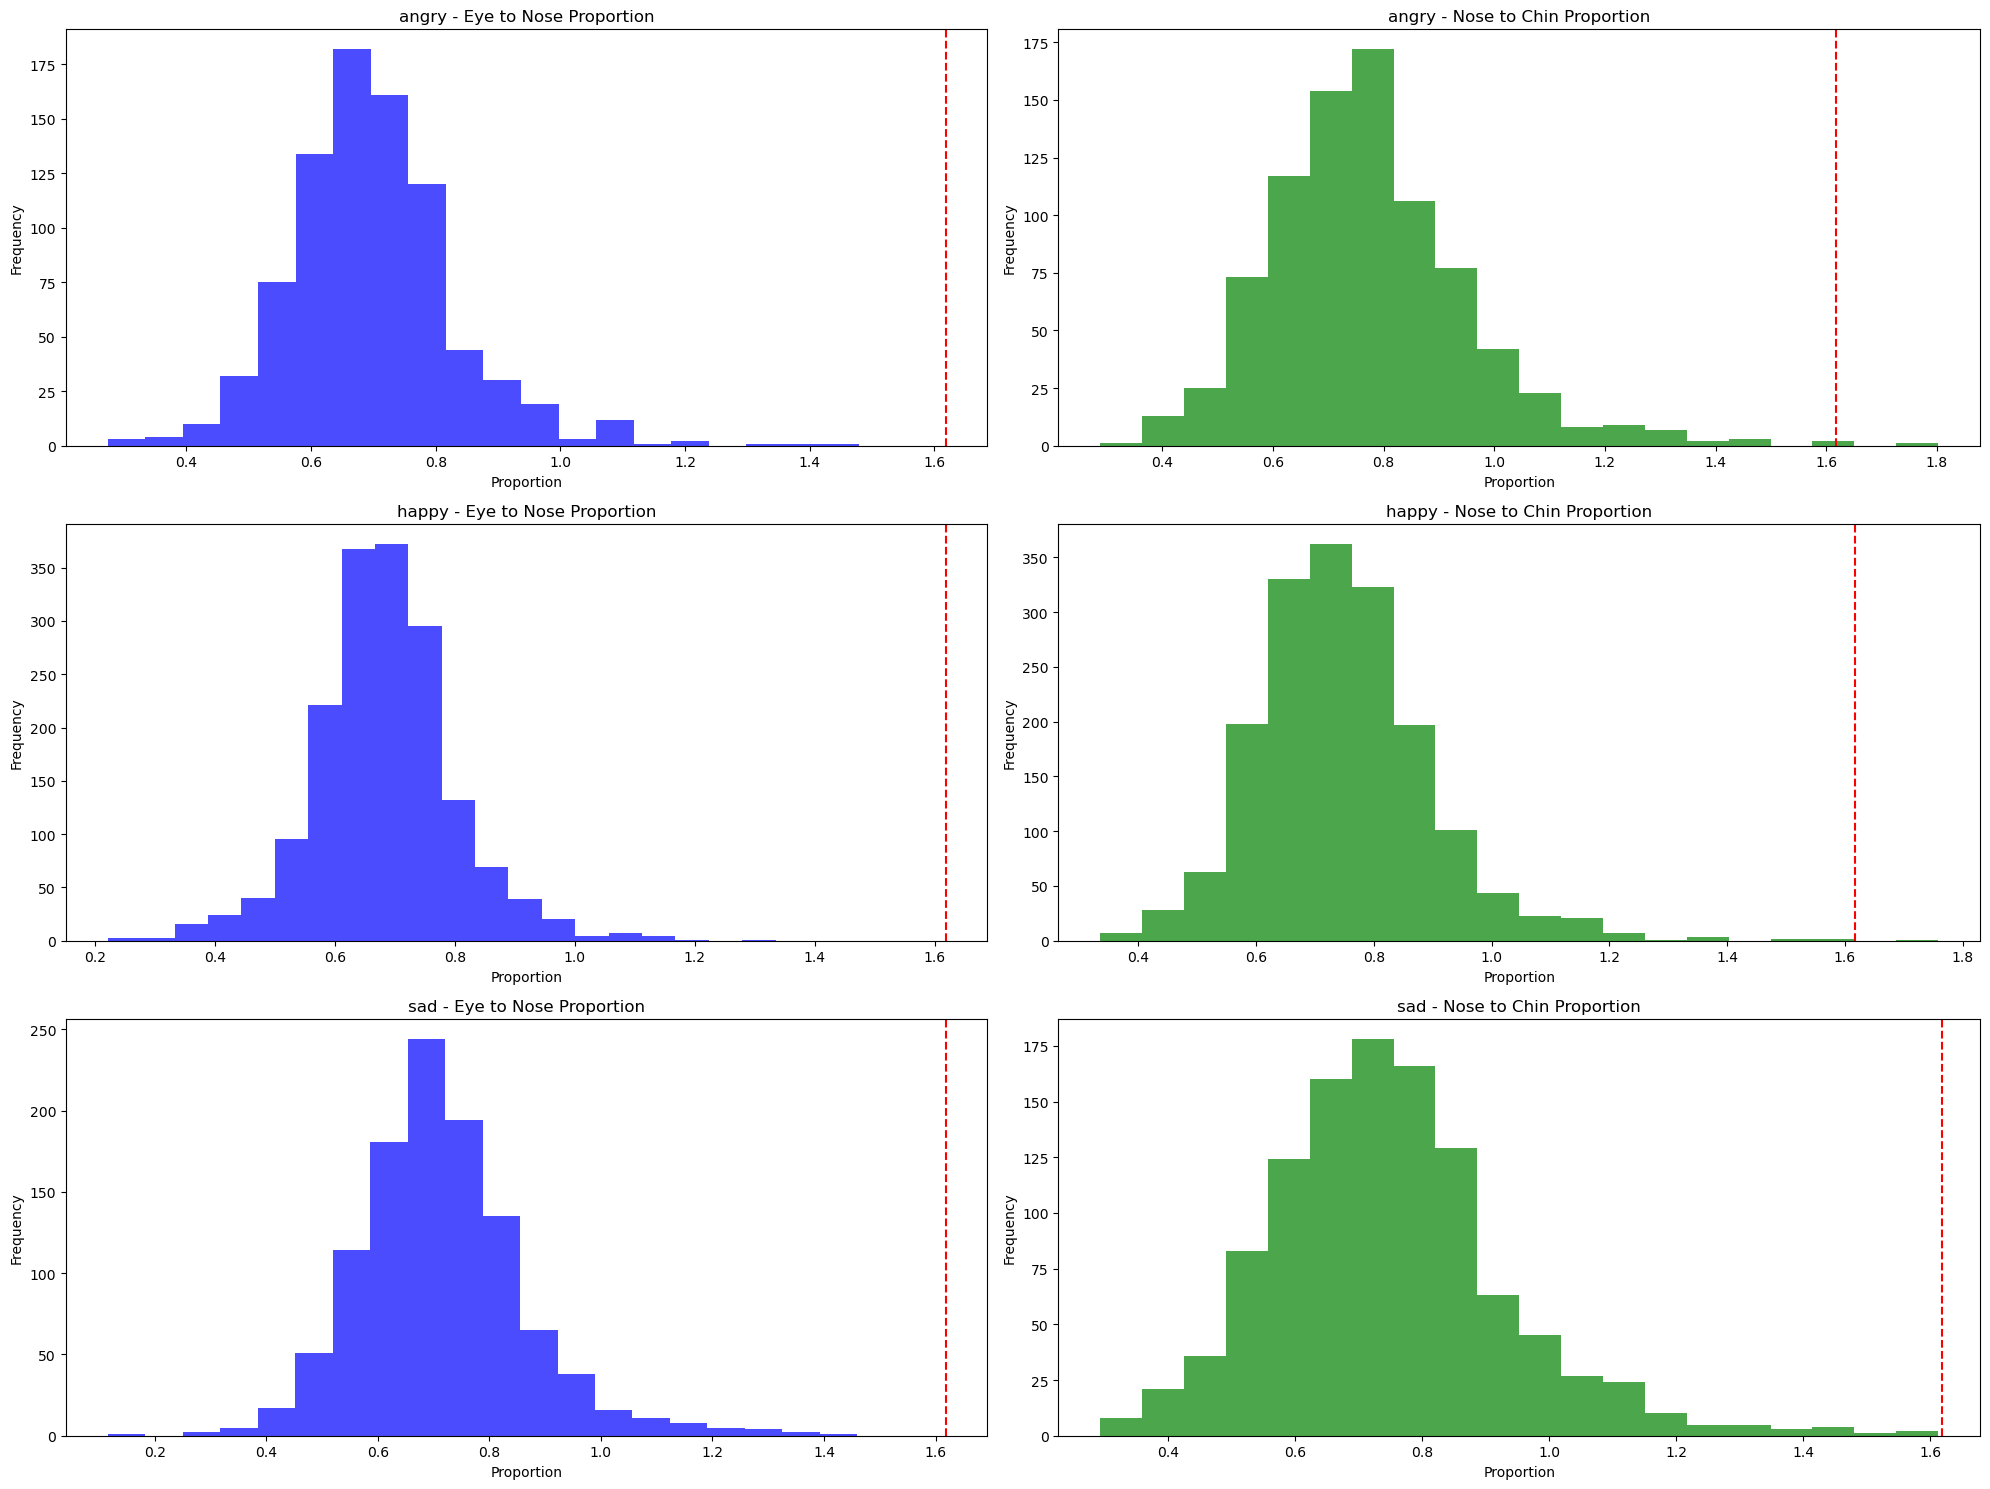

In [17]:
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
 
data_dir = 'Emotions'
image_exts = ['jpeg', 'jpg', 'png']
 
# Inicializar Mediapipe
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
 
# Función para calcular las proporciones áureas
def calculate_proportions(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error al cargar la imagen desde {image_path}. Verifica la ruta y asegúrate de que el archivo exista.")
        return None, None
 
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks is None:
            print(f"No se encontraron rostros en la imagen {image_path}")
            return None, None
        for face_landmarks in results.multi_face_landmarks:
            landmarks = face_landmarks.landmark
            h, w, _ = image.shape
            points = [
                (landmarks[33].x * w, landmarks[33].y * h),  # Ojo izquierdo
                (landmarks[263].x * w, landmarks[263].y * h), # Ojo derecho
                (landmarks[1].x * w, landmarks[1].y * h),     # Nariz
                (landmarks[152].x * w, landmarks[152].y * h)  # Mentón
            ]
            points = [(int(x), int(y)) for x, y in points]
            x1, y1 = points[0]
            x2, y2 = points[1]
            x3, y3 = points[2]
            x4, y4 = points[3]
 
            eye_distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            eye_to_nose = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
            nose_to_chin = np.sqrt((x4 - x3)**2 + (y4 - y3)**2)
 
            proportion_eye_nose = eye_distance/eye_to_nose
            proportion_nose_chin = eye_distance/nose_to_chin 
 
            return proportion_eye_nose, proportion_nose_chin
    return None, None
 
# Diccionario para almacenar las proporciones por clase de imagen
proportions_by_class = {}
 
# Iterar sobre las imágenes y calcular proporciones
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue
    proportions_by_class[image_class] = {'eye_nose': [], 'nose_chin': []}
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print(f'Image not in ext list {image_path}')
            os.remove(image_path)
            continue
        try:
            prop_eye_nose, prop_nose_chin = calculate_proportions(image_path)
            if prop_eye_nose and prop_nose_chin:
                proportions_by_class[image_class]['eye_nose'].append(prop_eye_nose)
                proportions_by_class[image_class]['nose_chin'].append(prop_nose_chin)
        except Exception as e:
            print(f'Issue with image {image_path}: {e}')
            continue
 
# Graficar las proporciones por clase de imagen
fig, ax = plt.subplots(nrows=len(proportions_by_class), ncols=2, figsize=(20, 5*len(proportions_by_class)))
 
for idx, (image_class, proportions) in enumerate(proportions_by_class.items()):
    ax[idx, 0].hist(proportions['eye_nose'], bins=20, color='blue', alpha=0.7)
    ax[idx, 0].axvline(x=1.618, color='r', linestyle='--')
    ax[idx, 0].set_title(f'{image_class} - Eye to Nose Proportion')
    ax[idx, 0].set_xlabel('Proportion')
    ax[idx, 0].set_ylabel('Frequency')
    ax[idx, 1].hist(proportions['nose_chin'], bins=20, color='green', alpha=0.7)
    ax[idx, 1].axvline(x=1.618, color='r', linestyle='--')
    ax[idx, 1].set_title(f'{image_class} - Nose to Chin Proportion')
    ax[idx, 1].set_xlabel('Proportion')
    ax[idx, 1].set_ylabel('Frequency')
 
plt.tight_layout()
plt.show()